## Import and Load Data

In [20]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Load the merged and clean dataset
data = pd.read_csv("../../data/ethusd_lasso_selected.csv", parse_dates=['time'])

# Print col
print(data.columns)

data

Index(['time', 'ln_RV_d,t', 'ln_RV_w,t', 'ln_RV_m,t', 'RV_d,t', 'RV_w,t',
       'RV_m,t', 'volume', 'CLF16OV', 'UEMPMEAN', 'AAAFFM'],
      dtype='object')


,time,"ln_RV_d,t","ln_RV_w,t","ln_RV_m,t","RV_d,t","RV_w,t","RV_m,t",volume,CLF16OV,UEMPMEAN,AAAFFM
0,2016-06-07,-5.672049,-4.627411,-4.411915,0.003441,0.009780,0.012132,60569.292389,158967,28.0,3.12
1,2016-06-08,-5.603745,-5.871006,-4.442125,0.003684,0.002820,0.011771,78019.604395,158967,28.0,3.12
2,2016-06-09,-6.374632,-5.914452,-4.447674,0.001704,0.002700,0.011706,18913.433977,158967,28.0,3.12
3,2016-06-10,-6.219604,-6.023593,-4.442528,0.001990,0.002421,0.011766,63321.457153,158967,28.0,3.12
4,2016-06-11,-5.987759,-6.003918,-4.456531,0.002509,0.002469,0.011603,37906.991730,158967,28.0,3.12
...,...,...,...,...,...,...,...,...,...,...,...
2636,2023-10-04,-7.876100,-7.239643,-7.914276,0.000380,0.000718,0.000365,3311.928462,167723,21.6,0.28
2637,2023-10-05,-8.136561,-7.259229,-7.904409,0.000293,0.000704,0.000369,2936.639328,167723,21.6,0.28
2638,2023-10-06,-8.028819,-7.261371,-7.909841,0.000326,0.000702,0.000367,4436.360475,167723,21.6,0.28
2639,2023-10-07,-9.962319,-7.282344,-7.921201,0.000047,0.000688,0.000363,953.564307,167723,21.6,0.28


## Data cleaning
### Features engineering

Since we are focused on the ln RV, we should drop the non ln values

In [21]:
# Drop the non-ln values
data = data.drop(columns=['RV_d,t', 'RV_w,t', 'RV_m,t'])

We also shifted the daily ln returns by 1

In [22]:
log_daily_rv = data['ln_RV_d,t']
log_weekly_rv = data['ln_RV_w,t']
log_monthly_rv = data['ln_RV_m,t']


# Shift the log RVs by 1
daily_shifted = log_daily_rv.shift(1).loc[data.index]
weekly_shifted = log_weekly_rv.shift(1).reindex(data.index, method='ffill')
monthly_shifted = log_monthly_rv.shift(1).reindex(data.index, method='ffill')

# Shift the log RVs by 2
daily_shifted_2 = log_daily_rv.shift(2).loc[data.index]
weekly_shifted_2 = log_weekly_rv.shift(2).reindex(data.index, method='ffill')
monthly_shifted_2 = log_monthly_rv.shift(2).reindex(data.index, method='ffill')

# Add the shifted log RVs to the dataset
data['ln_RV_d,t-1'] = daily_shifted
data['ln_RV_w,t-1'] = weekly_shifted
data['ln_RV_m,t-1'] = monthly_shifted
data['ln_RV_d,t-2'] = daily_shifted_2
data['ln_RV_w,t-2'] = weekly_shifted_2
data['ln_RV_m,t-2'] = monthly_shifted_2

# Shift volume by 1
data['volume_lag_1'] = data['volume'].shift(1).loc[data.index]

# Create helper columns for month and year
data['month'] = data['time'].dt.month
data['year'] = data['time'].dt.year

# Sort values to ensure correct shifting
data = data.sort_values(by=['year', 'month'])

# Perform a shift within each macroeconomic variable
for col in ['CLF16OV', 'UEMPMEAN', 'AAAFFM']:
    data[f'{col}_lag_1'] = data.groupby(['year', 'month'])[col].shift(1)

# Fill the NaN values correctly
data[['CLF16OV_lag_1', 'UEMPMEAN_lag_1', 'AAAFFM_lag_1']] = data[['CLF16OV_lag_1', 'UEMPMEAN_lag_1', 'AAAFFM_lag_1']].fillna(method='bfill')

# Drop helper columns
data.drop(columns=['month', 'year'], inplace=True)

# Drop the first row
data = data.dropna()

C:\Users\young\AppData\Local\Temp\ipykernel_22196\2569270546.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[['CLF16OV_lag_1', 'UEMPMEAN_lag_1', 'AAAFFM_lag_1']] = data[['CLF16OV_lag_1', 'UEMPMEAN_lag_1', 'AAAFFM_lag_1']].fillna(method='bfill')


### Train-test split
We are mindful that the data is a time series data, so we will not randomise the data for the train test split. We will run a 80/20 split instead. 

In [49]:
total_obs = len(data)
train_size = int(0.8 * total_obs)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Create the training features, taking in all variables except the target variable
X_train = train_data.copy()

# Drop time
X_train.drop('time', axis=1, inplace=True)

# Drop the target variables to prevent data leakage, but we should keep the shifted variables
X_train.drop('ln_RV_d,t', axis=1, inplace=True)
X_train.drop('ln_RV_w,t', axis=1, inplace=True)
X_train.drop('ln_RV_m,t', axis=1, inplace=True)
X_train.drop('volume', axis=1, inplace=True)

# Drop the non-lagged FREDMD data
X_train.drop('CLF16OV', axis=1, inplace=True)
X_train.drop('UEMPMEAN', axis=1, inplace=True)
X_train.drop('AAAFFM', axis=1, inplace=True)

# Make all columns numeric
X_train = X_train.apply(pd.to_numeric, errors='coerce')

# Y Var is the log of the daily RV
y_train = log_daily_rv.loc[train_data.index]
y_train = y_train.apply(pd.to_numeric, errors='coerce')

# Drop any rows with NaN values
X_train.dropna(inplace=True)
y_train = y_train.loc[X_train.index]

trained_features = X_train.columns.copy()  # Save the training feature names


## Random Forest
We will use a RF model to predict the realised variance

### Training the RF model

In [47]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

if X_train.shape[0] == y_train.shape[0]:
    rf_model.fit(X_train, y_train)
else:
    raise ValueError("Error: Inconsistent number of samples. Cannot train the model.")


Creating a one-day-ahead forecast

In [48]:
ln_rv_forecast = rf_model.predict(X_train.iloc[[-1]])[0]

### Updating the training sample
This is done by removing the oldest one and adding the latest one

### Out of sample performance
We will now test our model to see the performance. Do note that our OOS begins in 2019.

In [26]:
forecasts = []

# Use the test_data's index as the forecasting dates.
test_dates = test_data.index
total_iterations = len(test_dates)

# Get the initial forecast using the last observation in the training set.
ln_rv_forecast = rf_model.predict(X_train.iloc[[-1]])[0]

# Save the initial training window size.
window_size = X_train.shape[0]

for i, date in enumerate(test_dates):
    # Print the iteration count.
    print(f"Iteration {i+1} of {total_iterations}")
    
    # Copy the last row from X_train to keep all columns.
    new_observation = X_train.iloc[[-1]].copy()
    
    # Update only the dynamic columns with values for the current forecast date.
    new_observation['ln_RV_d,t-1'] = ln_rv_forecast
    new_observation['ln_RV_w,t-1']  = log_weekly_rv.asof(date)
    new_observation['ln_RV_m,t-1'] = log_monthly_rv.asof(date)
    new_observation['ln_RV_d,t-2'] = log_daily_rv.shift(2).asof(date)
    new_observation['ln_RV_w,t-2'] = log_weekly_rv.shift(2).asof(date)
    new_observation['ln_RV_m,t-2'] = log_monthly_rv.shift(2).asof(date)
    new_observation['volume_lag_1'] = data['volume_lag_1'].asof(date)
    new_observation['CLF16OV_lag_1'] = data['CLF16OV_lag_1'].asof(date)
    new_observation['UEMPMEAN_lag_1'] = data['UEMPMEAN_lag_1'].asof(date)
    new_observation['AAAFFM_lag_1'] = data['AAAFFM_lag_1'].asof(date)
    
    # Set the index of the new observation to the current forecast date.
    new_observation.index = [date]
    
    # Append the new observation to X_train.
    X_train = pd.concat([X_train, new_observation]) # Conc the test set obs instead
    
    # Update y_train:
    if date in log_daily_rv.index:
        new_target = log_daily_rv.loc[date]
    else:
        new_target = ln_rv_forecast
    y_train = pd.concat([y_train, pd.Series([new_target], index=[date])])
    
    # Maintain a fixed training window by dropping the oldest observations.
    if len(X_train) > window_size:
        X_train = X_train.iloc[-window_size:]
        y_train = y_train.iloc[-window_size:]
    
    # Ensure that X_train and y_train share the same indices.
    common_index = X_train.index.intersection(y_train.index)
    X_train = X_train.loc[common_index]
    y_train = y_train.loc[common_index]
    
    # Retrain the model, again
    rf_model.fit(X_train, y_train)
    
    ln_rv_forecast = rf_model.predict(new_observation)[0]
    rv_forecast = np.exp(ln_rv_forecast)  # Convert from log-scale.
    forecasts.append(rv_forecast)

print("Forecasts:", forecasts)


Iteration 1 of 528
Iteration 2 of 528
Iteration 3 of 528
Iteration 4 of 528
Iteration 5 of 528
Iteration 6 of 528
Iteration 7 of 528
Iteration 8 of 528
Iteration 9 of 528
Iteration 10 of 528
Iteration 11 of 528
Iteration 12 of 528
Iteration 13 of 528
Iteration 14 of 528
Iteration 15 of 528
Iteration 16 of 528
Iteration 17 of 528
Iteration 18 of 528
Iteration 19 of 528
Iteration 20 of 528
Iteration 21 of 528
Iteration 22 of 528
Iteration 23 of 528
Iteration 24 of 528
Iteration 25 of 528
Iteration 26 of 528
Iteration 27 of 528
Iteration 28 of 528
Iteration 29 of 528
Iteration 30 of 528
Iteration 31 of 528
Iteration 32 of 528
Iteration 33 of 528
Iteration 34 of 528
Iteration 35 of 528
Iteration 36 of 528
Iteration 37 of 528
Iteration 38 of 528
Iteration 39 of 528
Iteration 40 of 528
Iteration 41 of 528
Iteration 42 of 528
Iteration 43 of 528
Iteration 44 of 528
Iteration 45 of 528
Iteration 46 of 528
Iteration 47 of 528
Iteration 48 of 528
Iteration 49 of 528
Iteration 50 of 528
Iteration

### Saving results to CSV
Using a high end PC, it already takes 10 mins to do the forecast, so to save the trouble of running the code, we saved the results in a CSV

In [43]:
print(len(forecasts))
print(len(test_dates))

# Save forecasts to a DataFrame and then csv
forecast_df = pd.DataFrame(forecasts, index=test_dates[:len(forecasts)], columns=['forecast'])
forecast_df.to_csv("../../results/rf_forecast.csv")

528
528


#### RMSFE
We will use RMSFE to evaluate the results

In [41]:
# The line below will read the forecasts from the csv file, use it if you are not running the entire script
forecasts = pd.read_csv("../../results/rf_forecast.csv", index_col=0, parse_dates=True)['forecast']

forecast_dates = test_data.index
forecasts_series = pd.Series(forecasts, index=forecast_dates)
ln_rv = data['ln_RV_d,t'].loc[forecast_dates]
actual_rv = np.exp(ln_rv)

errors = forecasts_series - actual_rv
rmsfe = np.sqrt(np.mean(errors ** 2))
print("RMSFE:", rmsfe)


RMSFE: 0.0009772534539360038


#### Feature Importance
We examined the feature importance of the RF model. We can note that the one day realised variance lag seems to be the most significant, followed by volume and then daily returns.

In [50]:
importances = np.round(rf_model.feature_importances_, 4)
feature_importance_df = pd.DataFrame({
    'Feature': trained_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances (impurity based):")
print(feature_importance_df)



Feature Importances (impurity based):
          Feature  Importance
0     ln_RV_d,t-1      0.6381
1     ln_RV_w,t-1      0.0699
3     ln_RV_d,t-2      0.0542
4     ln_RV_w,t-2      0.0532
6    volume_lag_1      0.0497
2     ln_RV_m,t-1      0.0368
5     ln_RV_m,t-2      0.0297
8  UEMPMEAN_lag_1      0.0234
7   CLF16OV_lag_1      0.0230
9    AAAFFM_lag_1      0.0219


#### Plotting out
We will now plot out a line graph of data. 

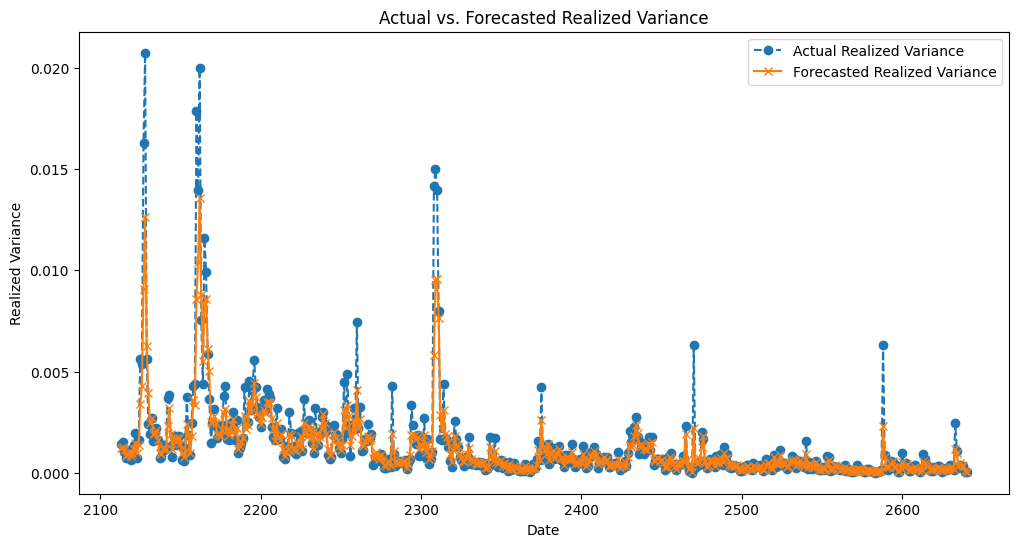

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(actual_rv.index, actual_rv, label="Actual Realized Variance", marker='o', linestyle='--')
plt.plot(forecasts_series.index, forecasts_series, label="Forecasted Realized Variance", marker='x', linestyle='-')
plt.xlabel("Date")
plt.ylabel("Realized Variance")
plt.title("Actual vs. Forecasted Realized Variance")
plt.legend()
plt.show()

## HAR
Heterogenous Autoregression (HAR) is a form of autoregression that uses past data to predict the future data. 

We will use the same train test split above

### Reindexing daily and monthly rv

In [31]:
har_df = pd.DataFrame({
    'lag1_log_rv': log_daily_rv.shift(1),
    'lag_weekly': log_weekly_rv.shift(1),
    'lag_monthly': log_monthly_rv.shift(1),
    'log_daily_rv': log_daily_rv
})

# Drop initial missing observations
har_df = har_df.dropna()


### Train test split
We will still be using 80/20

In [32]:
train_df = har_df.iloc[:train_size]
test_df = har_df.iloc[train_size:]

### Training the model

In [33]:
X_train = train_df[['lag1_log_rv', 'lag_weekly', 'lag_monthly']]
y_train = train_df['log_daily_rv']
X_train_const = sm.add_constant(X_train)

# Fit the model
har_model = sm.OLS(y_train, X_train_const).fit()
print(har_model.summary())


                            OLS Regression Results                            
Dep. Variable:           log_daily_rv   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     1172.
Date:                Wed, 05 Feb 2025   Prob (F-statistic):               0.00
Time:                        02:07:46   Log-Likelihood:                -2047.6
No. Observations:                2111   AIC:                             4103.
Df Residuals:                    2107   BIC:                             4126.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.7314      0.109     -6.699      

### Out of sample performance
Same as RF, we will run a one step ahead OOS forecasting for the trest data

In [34]:
forecasts = []  # to store forecasted log realized variance values

# For the first forecast, use the last observation from the training set:
last_train = train_df.iloc[-1]
prev_forecast = last_train['log_daily_rv'] 

# We'll forecast for each date in the test set:
for date in test_df.index:
    lag1 = prev_forecast
    lag_weekly_value = test_df.loc[date, 'lag_weekly']
    lag_monthly_value = test_df.loc[date, 'lag_monthly']
    
    # Create a DataFrame with a constant term and the current features:
    X_new = pd.DataFrame({
        'const': [1],
        'lag1_log_rv': [lag1],
        'lag_weekly': [lag_weekly_value],
        'lag_monthly': [lag_monthly_value ]
    })
    
    # Forecast log realized variance:
    forecast_log_rv = har_model.predict(X_new)[0]
    forecasts.append(forecast_log_rv)
    prev_forecast = forecast_log_rv
    
    # Convert forecasts from log scale back to the original variance scale:
forecasts_exp = np.exp(forecasts)

# Also convert the actual log values in the test set back to variance scale:
actual_exp = np.exp(test_df['log_daily_rv'])



#### RMSFE

In [35]:
errors = forecasts_exp - actual_exp
rmsfe = np.sqrt(np.mean(errors**2))
print("HAR Model RMSFE:", rmsfe)

HAR Model RMSFE: 0.002108840747482346


#### Plot of HAR


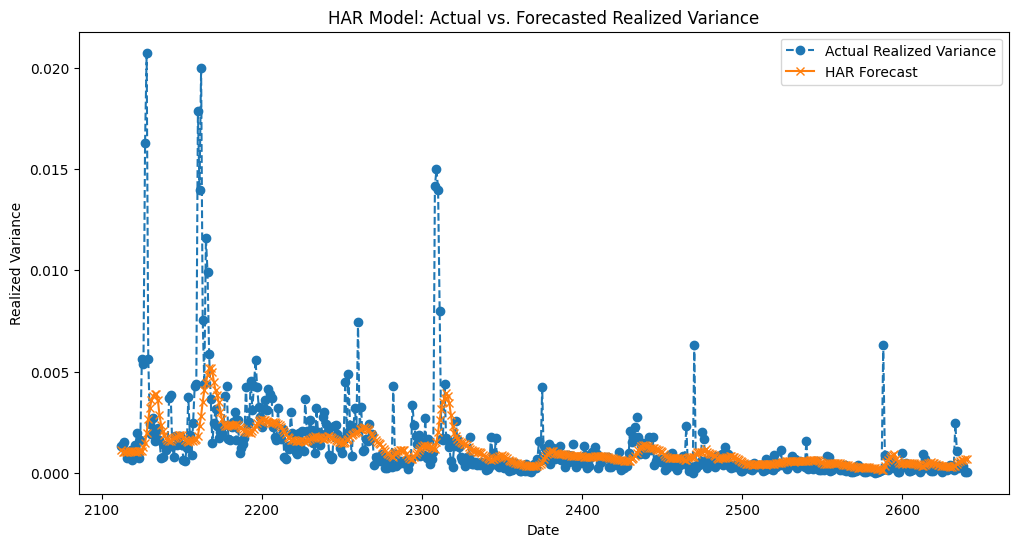

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(test_df.index, actual_exp, label="Actual Realized Variance", marker='o', linestyle='--')
plt.plot(test_df.index, forecasts_exp, label="HAR Forecast", marker='x', linestyle='-')
plt.xlabel("Date")
plt.ylabel("Realized Variance")
plt.title("HAR Model: Actual vs. Forecasted Realized Variance")
plt.legend()
plt.show()
